# Market Making with Alpha - Basis


<div class='alert alert-info'>
    
**Note:** This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href='https://www.binance.com/en/support/announcement/binance-updates-usd%E2%93%A2-margined-futures-liquidity-provider-program-2024-06-03-fefc6aa25e0947e2bf745c1c56bea13e'>Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
    
</div>

In [1]:
import datetime
import os

import numpy as np

from numba import njit, uint64
from numba.typed import Dict

from hftbacktest import (
    BacktestAsset,
    ROIVectorMarketDepthBacktest,
    GTX,
    LIMIT,
    BUY,
    SELL,
    BUY_EVENT,
    SELL_EVENT,
    Recorder
)
from hftbacktest.stats import LinearAssetRecord

import polars as pl

Download L1 (book ticker) data to calculate the basis between spot and futures.

In [3]:
start_date = datetime.datetime.strptime('20240901', '%Y%m%d')
end_date = datetime.datetime.strptime('20241031', '%Y%m%d')
tardis_token = ""

In [4]:
def download_from_tardis(exchange, stream, symbol, start_date, end_date, output_path, token):
    date = start_date
    while date <= end_date:
        yyyymmdd = date.strftime('%Y%m%d')
        year = yyyymmdd[:4]
        month = yyyymmdd[4:6]
        day = yyyymmdd[6:]
        output_file = os.path.join(output_path, f'{symbol}_{yyyymmdd}.csv.gz')
        header = f'"Authorization: Bearer {token}"'
        !wget --header={header} https://datasets.tardis.dev/v1/{exchange}/{stream}/{year}/{month}/{day}/{symbol}.csv.gz -O {output_file}
        date += datetime.timedelta(days=1)

In [5]:
download_from_tardis('binance', 'book_ticker', 'BTCUSDT', start_date, end_date, 'spot/book_ticker/BTCUSDT', tardis_token)
download_from_tardis('binance-futures', 'book_ticker', 'BTCUSDT', start_date, end_date, 'usdm/book_ticker/BTCUSDT', tardis_token)

Precompute the basis for faster backtesting.

In [7]:
def load_bookticker(file):
    return pl.read_csv(file, schema={
        'exchange': pl.String,
        'symbol': pl.String,
        'timestamp': pl.Int64,
        'local_timestamp': pl.Int64,
        'ask_amount': pl.Float64,
        'ask_price': pl.Float64,
        'bid_price': pl.Float64,
        'bid_amount': pl.Float64
    }).with_columns(
        pl.col('local_timestamp').cast(pl.Datetime),
        mid_price = (.5 * (pl.col('bid_price') + pl.col('ask_price'))),
    ).select(['local_timestamp', 'mid_price'])

def prepare_px_basis(spot_file, futures_file, sampling_interval, rolling_window):
    spot = load_bookticker(spot_file)
    futures = load_bookticker(futures_file)

    # Resamples prices to calculate the basis.
    spot_rs = spot.group_by_dynamic(
        index_column='local_timestamp',
        every=sampling_interval
    ).agg(
        pl.col('mid_price').last()
    ).upsample(
        time_column='local_timestamp',
        every=sampling_interval
    ).select(pl.all().forward_fill())
    
    futures_rs = futures.group_by_dynamic(
        index_column='local_timestamp',
        every=sampling_interval
    ).agg(
        pl.col('mid_price').last(),
    ).upsample(
        time_column='local_timestamp',
        every=sampling_interval
    ).select(pl.all().forward_fill())

    return spot_rs.join(
        futures_rs,
        left_on='local_timestamp',
        right_on='local_timestamp',
        how='full'
    ).with_columns(
        rolling_mean_basis=(
            pl.col('mid_price_right').forward_fill() - pl.col('mid_price').forward_fill() # Computes the basis
        ).rolling_mean(window_size=rolling_window), # Computes the moving average of the basis over the given window.
    ).select(
        local_timestamp=pl.col('local_timestamp').dt.timestamp('ns'),
        spot=pl.col('mid_price'),
        basis=pl.col('rolling_mean_basis')
    )

In [8]:
data = []
date = start_date
while date <= end_date:
    data.append(prepare_px_basis(
        f'spot/book_ticker/BTCUSDT/BTCUSDT_{date.strftime("%Y%m%d")}.csv.gz',
        f'usdm/book_ticker/BTCUSDT/BTCUSDT_{date.strftime("%Y%m%d")}.csv.gz',
        '100ms',
        3000 # 5-minute
    ).to_numpy())
    date += datetime.timedelta(days=1)
precompute_data = np.concatenate(data, axis=0)

In [9]:
np.savez_compressed('px_basis_BTCUSDT_5m', data=precompute_data)

In [10]:
precompute_data = np.load('px_basis_BTCUSDT_5m.npz')['data']

A market-making model based on the basis. Since the basis is often considered stationary, various time series analysis techniques, such as MA, AR, ARMA and etc, can be applied. Here, the simplest model, the Moving Average, is used for demonstration. This approach assumes that the basis will revert to the average of a given past period.

In [12]:
@njit
def basis_mm(
    hbt,
    stat,
    half_spread,
    skew,
    precompute_data,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
):
    asset_no = 0

    tick_size = hbt.depth(0).tick_size
    lot_size = hbt.depth(0).lot_size
    
    roi_lb_tick = int(round(roi_lb / tick_size))
    roi_ub_tick = int(round(roi_ub / tick_size))

    data_i = 0
    last_spot = np.nan
    last_basis = np.nan
    
    while hbt.elapse(interval) == 0:
        hbt.clear_inactive_orders(asset_no)
        
        depth = hbt.depth(asset_no)
        position = hbt.position(asset_no)
        orders = hbt.orders(asset_no)

        best_bid = depth.best_bid
        best_ask = depth.best_ask
        
        mid_price = (best_bid + best_ask) / 2.0

        #--------------------------------------------------------
        # Computes bid price and ask price.
        
        order_qty = max(round((order_qty_dollar / mid_price) / lot_size) * lot_size, lot_size)
        
        normalized_position = position / order_qty

        relative_bid_depth = half_spread + skew * normalized_position
        relative_ask_depth = half_spread - skew * normalized_position

        # Reads the latest observable spot price and basis from the precomputed data.
        while data_i < len(precompute_data):
            if precompute_data[data_i, 0] > hbt.current_timestamp:
                if data_i > 0:
                    last_spot = precompute_data[data_i - 1, 1]
                    last_basis = precompute_data[data_i - 1, 2]
                break
            data_i += 1
        # Our fair price is calculated as the spot price + the rolling average of the basis
        fair_px = last_spot + last_basis

        bid_price = min(fair_px * (1.0 - relative_bid_depth), best_bid)
        ask_price = max(fair_px * (1.0 + relative_ask_depth), best_ask)
        
        bid_price = np.floor(bid_price / tick_size) * tick_size
        ask_price = np.ceil(ask_price / tick_size) * tick_size
        
        #--------------------------------------------------------
        # Updates quotes.
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price < max_position_dollar and np.isfinite(bid_price):
            for i in range(grid_num):
                bid_price_tick = round(bid_price / tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[uint64(bid_price_tick)] = bid_price
                
                bid_price -= grid_interval

        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.uint64, np.float64)
        if position * mid_price > -max_position_dollar and np.isfinite(ask_price):
            for i in range(grid_num):
                ask_price_tick = round(ask_price / tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[uint64(ask_price_tick)] = ask_price

                ask_price += grid_interval
                
        order_values = orders.values();
        while order_values.has_next():
            order = order_values.get()
            # Cancels if a working order is not in the new grid.
            if order.cancellable:
                if (
                    (order.side == BUY and order.order_id not in new_bid_orders)
                    or (order.side == SELL and order.order_id not in new_ask_orders)
                ):
                    hbt.cancel(asset_no, order.order_id, False)
                    
        for order_id, order_price in new_bid_orders.items():
            # Posts a new buy order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_buy_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
                
        for order_id, order_price in new_ask_orders.items():
            # Posts a new sell order if there is no working order at the price on the new grid.
            if order_id not in orders:
                hbt.submit_sell_order(asset_no, order_id, order_price, order_qty, GTX, LIMIT, False)
        
        # Records the current state for stat calculation.
        stat.record(hbt)

In [13]:
%%time

roi_lb = 10000
roi_ub = 90000

latency_data = []
date = start_date
while date <= end_date:
    latency_data.append('latency/order_latency_{}.npz'.format(date.strftime('%Y%m%d')))
    date += datetime.timedelta(days=1)

data = []
date = start_date
while date <= end_date:
    data.append('data2/btcusdt_{}.npz'.format(date.strftime('%Y%m%d')))
    date += datetime.timedelta(days=1)

asset = (
    BacktestAsset()
        .data(data)
        .initial_snapshot('data2/btcusdt_20240831_eod.npz')
        .linear_asset(1.0) 
        .intp_order_latency(latency_data)
        .power_prob_queue_model(3)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 60_000_000)

half_spread = 0.0003 # a ratio relative to the fair price
skew = half_spread / 20
interval = 100_000_000 # in nanoseconds. 100ms
order_qty_dollar = 50_000
max_position_dollar = order_qty_dollar * 20
grid_num = 1
grid_interval = hbt.depth(0).tick_size

basis_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    precompute_data,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
)

hbt.close()

recorder.to_npz('stats/underlying_btcusdt_basis_5m.npz')

CPU times: user 1h 2min 41s, sys: 1min 45s, total: 1h 4min 27s
Wall time: 40min 22s


In [14]:
data = np.load('stats/underlying_btcusdt_basis_5m.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats(book_size=1_000_000)
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-09-01 00:00:00,2024-10-31 23:55:00,3.280936,4.380048,0.05166,0.024406,537.702738,26.885072,2.116701,0.000032,1.0409e6


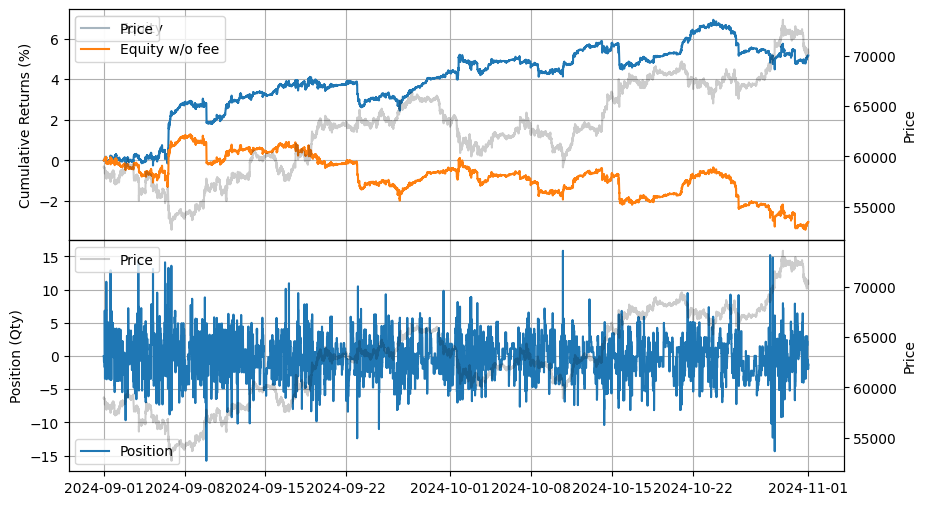

In [15]:
stats.plot()

On Binance, the BTCFDUSD spot market has a higher trading volume than the BTCUSDT spot market. BTCFDUSD records a daily trading volume of \\$3 billion, while BTCUSDT has \\$2.5 billion. Alternatively, you may consider using the exact index rather than a specific spot.

You can find the weights composing the index using the API. https://developers.binance.com/docs/derivatives/usds-margined-futures/market-data/rest-api/Composite-Index-Symbol-Information

In [17]:
download_from_tardis('binance', 'book_ticker', 'BTCFDUSD', start_date, end_date, 'spot/book_ticker/BTCFDUSD', tardis_token)

In [18]:
data = []
date = start_date
while date <= end_date:
    data.append(prepare_px_basis(
        f'spot/book_ticker/BTCFDUSD/BTCFDUSD_{date.strftime("%Y%m%d")}.csv.gz',
        f'usdm/book_ticker/BTCUSDT/BTCUSDT_{date.strftime("%Y%m%d")}.csv.gz',
        '100ms',
        3000 # 5-minute
    ).to_numpy())
    date += datetime.timedelta(days=1)
precompute_data = np.concatenate(data, axis=0)

In [19]:
np.savez_compressed('px_basis_BTCFDUSD_5m', data=precompute_data)

In [20]:
precompute_data = np.load('px_basis_BTCFDUSD_5m.npz')['data']

In [21]:
%%time

roi_lb = 10000
roi_ub = 90000

latency_data = []
date = start_date
while date <= end_date:
    latency_data.append('latency/order_latency_{}.npz'.format(date.strftime('%Y%m%d')))
    date += datetime.timedelta(days=1)

data = []
date = start_date
while date <= end_date:
    data.append('data2/btcusdt_{}.npz'.format(date.strftime('%Y%m%d')))
    date += datetime.timedelta(days=1)

asset = (
    BacktestAsset()
        .data(data)
        .initial_snapshot('data2/btcusdt_20240831_eod.npz')
        .linear_asset(1.0) 
        .intp_order_latency(latency_data)
        .power_prob_queue_model(3)
        .no_partial_fill_exchange()
        .trading_value_fee_model(-0.00005, 0.0007)
        .tick_size(0.1)
        .lot_size(0.001)
        .roi_lb(roi_lb)    
        .roi_ub(roi_ub)
)

hbt = ROIVectorMarketDepthBacktest([asset])

recorder = Recorder(1, 60_000_000)

half_spread = 0.0003 # a ratio relative to the fair price
skew = half_spread / 20
interval = 100_000_000 # in nanoseconds. 100ms
order_qty_dollar = 50_000
max_position_dollar = order_qty_dollar * 20
grid_num = 1
grid_interval = hbt.depth(0).tick_size

basis_mm(
    hbt,
    recorder.recorder,
    half_spread,
    skew,
    precompute_data,
    interval,
    order_qty_dollar,
    max_position_dollar,
    grid_num,
    grid_interval,
    roi_lb,
    roi_ub
)

hbt.close()

recorder.to_npz('stats/underlying_btcfdusd_basis_5m.npz')

CPU times: user 1h 5min 24s, sys: 1min 50s, total: 1h 7min 14s
Wall time: 42min 59s


In [22]:
data = np.load('stats/underlying_btcfdusd_basis_5m.npz')['0']
stats = (
    LinearAssetRecord(data)
        .resample('5m')
        .stats(book_size=1_000_000)
)
stats.summary()

start,end,SR,Sortino,Return,MaxDrawdown,DailyNumberOfTrades,DailyTurnover,ReturnOverMDD,ReturnOverTrade,MaxPositionValue
datetime[μs],datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64
2024-09-01 00:00:00,2024-10-31 23:55:00,2.069684,2.647596,0.045228,0.047641,479.043661,23.952189,0.949337,0.000031,1.0376e6


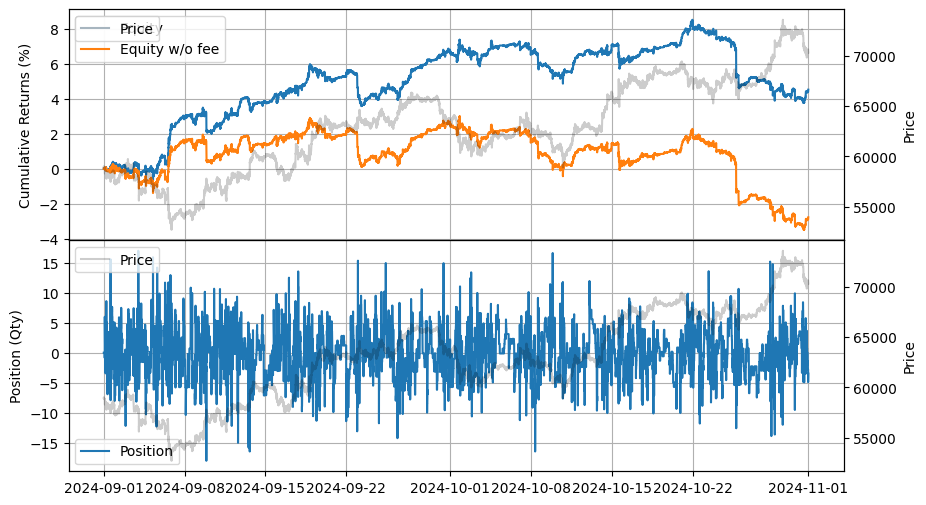

In [23]:
stats.plot()